In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Предсказывать будем цены, а не доходности.
Так как цены сами по себе предсказывать спроще, они менее похожи на шум, а также подлежат более-менее нормальной декомпозиции. Доходности же можно вычислить, исходя из формулы: $${r_t = \frac{y_t}{y_{t - 1} } - 1}$$

# Загрузка данных

In [2]:
df = pd.read_csv("../Data/American Companies/FORD 1994 2022.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,02.06.1972,2.153220,2.173495,2.141055,2.149165,0.266799,1174468
1,05.06.1972,2.149165,2.169440,2.141055,2.149165,0.266799,5209582
2,06.06.1972,2.149165,2.157275,2.116725,2.124835,0.263778,1424158
3,07.06.1972,2.124835,2.137000,2.112670,2.112670,0.262268,675088
4,08.06.1972,2.112670,2.128890,2.096449,2.096449,0.260255,1038834
...,...,...,...,...,...,...,...
12740,08.12.2022,13.200000,13.260000,13.070000,13.120000,13.120000,32376300
12741,09.12.2022,13.040000,13.360000,13.040000,13.180000,13.180000,41531600
12742,12.12.2022,13.200000,13.470000,13.100000,13.460000,13.460000,35473800
12743,13.12.2022,13.780000,13.920000,13.370000,13.570000,13.570000,57872100


In [3]:
open_price = df.Open
date = df.Date.apply(lambda x: pd.to_datetime(x, dayfirst= True))

In [4]:
bad_data = []
for ind, el in enumerate(open_price):
    try:
        float(el)
        assert(el != "0")
    except:
        print(el)
        bad_data.append(ind)

In [5]:
bad_data = np.array(bad_data)

In [6]:
open_price = open_price.drop(bad_data)
dates = date.drop(bad_data)

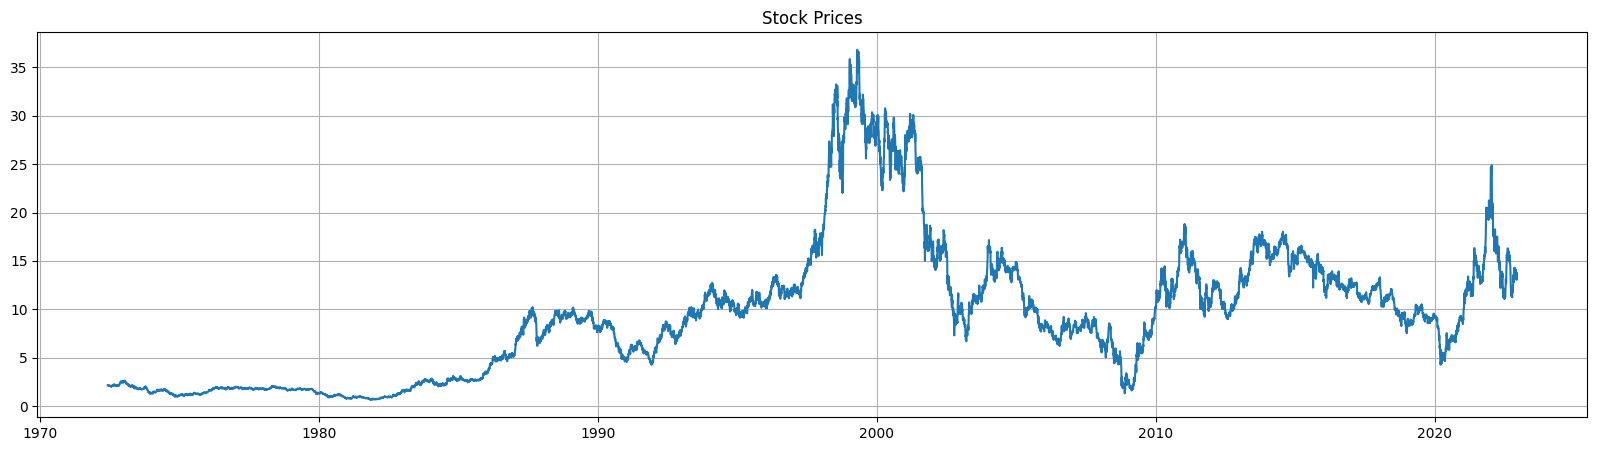

In [7]:
plt.figure(figsize= (20, 5))
plt.title("Stock Prices")
plt.plot(dates[:], open_price[:])
plt.grid(True)
plt.show()

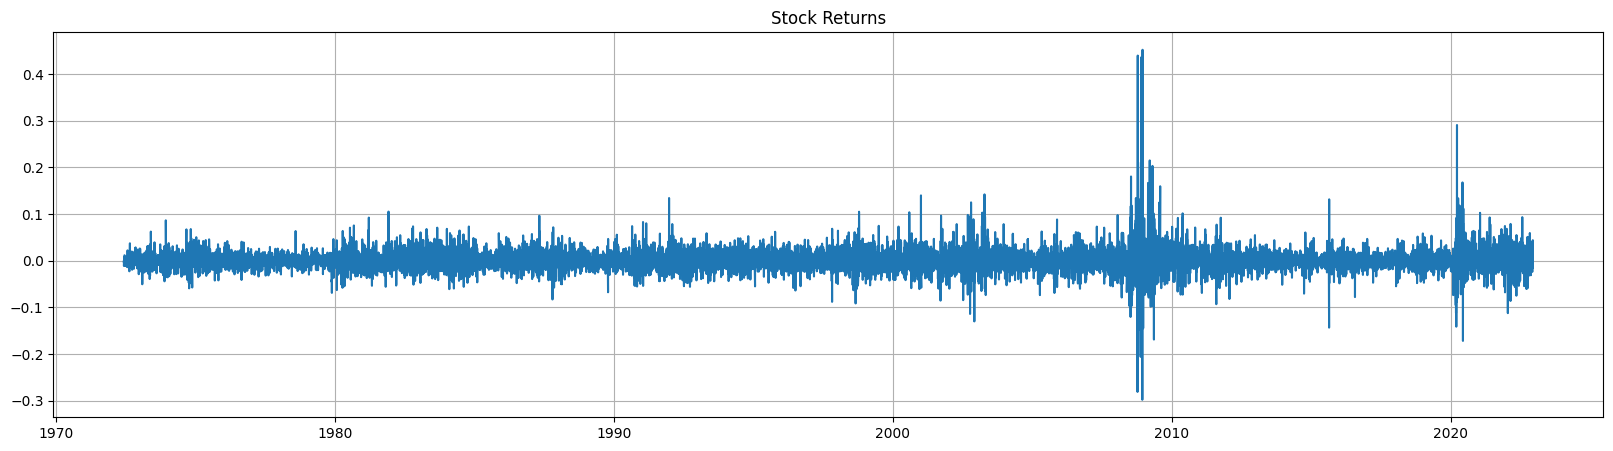

In [8]:
plt.figure(figsize= (20, 5))
plt.title("Stock Returns")
plt.plot(dates[1:], open_price.pct_change()[1:])
plt.grid(True)
plt.show()

In [9]:
open_price = open_price.astype(np.float32).to_numpy()
dates = dates.to_numpy()

# Преобразование данных во входные данные

In [10]:
def data_to_X_y(x, window_size= 40):
    X = []
    y = []
    for i in range(len(x) - window_size):
        row = list(map(lambda a: [a], x[i:i + window_size]))
        X.append(np.array(row))
        col = [x[i + window_size]]
        y.append(np.array(col))

    return np.array(X), np.array(y)

## Denoising procedure

### Multiple Stage SSA denoising

In [11]:
from Functions.SSA import SSA
from Functions.EMD_CMSE_SSA_Reconstruction import denoise

In [12]:
# np.random.seed(42)
# open_price = np.linspace(-5, 5, 4000)
# open_price = open_price * np.cos(open_price) + np.random.randn(open_price.shape[0])

L = 2
m_opt, reconstructed_series = SSA.multiple_stage_denoising(open_price, L, max_iter= 500)
m_opt, reconstructed_series.shape

Dividing loop:   0%|          | 0/500 [00:00<?, ?it/s]

(0, (12745,))

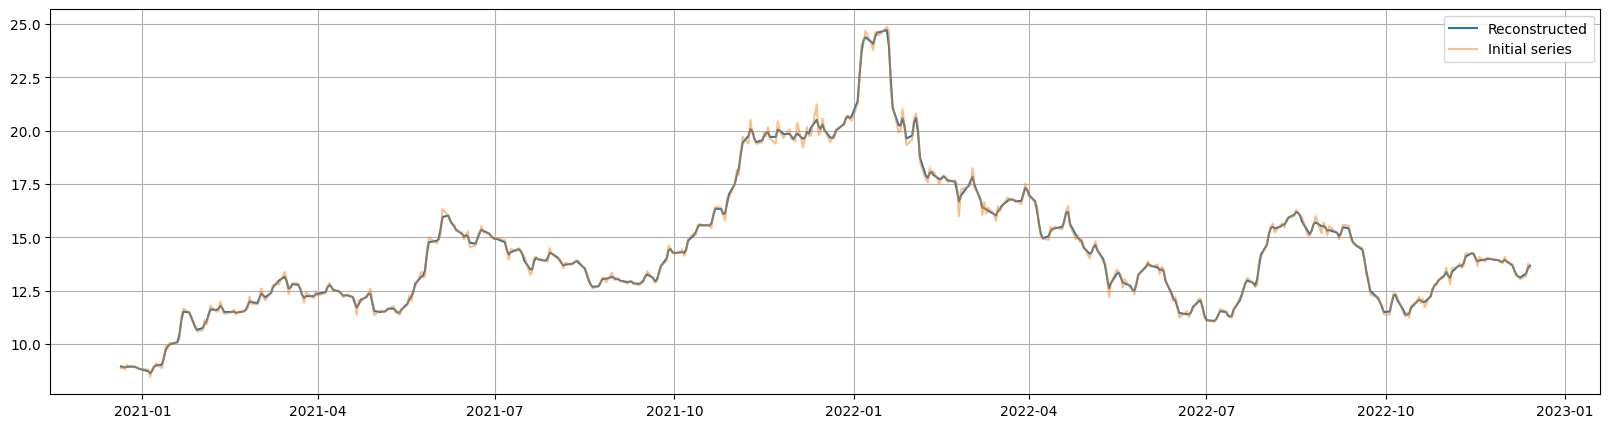

In [13]:
start = -500
end = None

plt.figure(figsize= (20, 5))
plt.plot(dates[start:end], reconstructed_series[start:end], label= "Reconstructed")
plt.plot(dates[start:end], open_price[start:end], label= "Initial series", alpha= 0.5)
plt.grid(True)
plt.legend(loc= "best")
plt.show()

### SSA + EMD denoising

In [14]:
# x_hat = SSA.get_components(open_price, L)
# reconstructed_series, (imfs, norms) = denoise(x_hat, open_price)
#
# reconstructed_series.shape, open_price.shape, imfs.shape, norms.shape

In [15]:
# def plot_initial_series_and_reconstructed(reconstructed_series, intial_series, dates= None, start= None, end= None, imfs= None, norms= None):
#
#     plt.figure(figsize= (20, 5))
#     if dates is not None:
#         plt.plot(dates[start:end], intial_series[start:end], label= "Intial series", alpha= 0.5)
#         plt.plot(dates[start:end], reconstructed_series[start:end], label= "Reconstructed")
#     else:
#         plt.plot(intial_series[start:end], label= "Intial series", alpha= 0.5)
#         plt.plot(reconstructed_series[start:end], label= "Reconstructed")
#
#     plt.grid(True)
#     plt.legend(loc= "best")
#     plt.show()
#
#     if imfs is not None:
#
#         plt.figure(figsize= (20, 5))
#         plt.title("IMFs' Norms")
#         plt.plot(norms[:-1])
#         plt.scatter(np.arange(len(norms) - 1), norms[:-1], c= "orange")
#         plt.grid(True)
#         plt.show()
#
#         for ind, imf in enumerate(imfs):
#             plt.figure(figsize= (20, 5))
#             plt.plot(imf)
#             plt.title(f"IMF: {ind}. Norm: {norms[ind]}")
#             plt.grid(True)
#             plt.show()

In [16]:
# plot_initial_series_and_reconstructed(reconstructed_series, open_price, start= None, end= None, imfs= imfs, norms= norms)

### Формирование матрицы траекторий

In [17]:
WINDOW_SIZE = 200 #40
X, y = data_to_X_y(reconstructed_series, window_size= WINDOW_SIZE)
dates_x, dates_y = data_to_X_y(dates, window_size= WINDOW_SIZE)

X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)

X.shape, X.dtype, y.shape, y.dtype

(torch.Size([12545, 200, 1]),
 torch.float32,
 torch.Size([12545, 1]),
 torch.float32)

# Разбивка на обучение и тест

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_test_x, dates_train_y, dates_test_y = train_test_split(
    dates_x, dates_y,
    test_size= 0.1,
    shuffle= False
)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_val_x, dates_train_y, dates_val_y = train_test_split(
    dates_train_x, dates_train_y,
    test_size= 0.1,
    shuffle= False
)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([10161, 200, 1]),
 torch.Size([1129, 200, 1]),
 torch.Size([1255, 200, 1]),
 torch.Size([10161, 1]),
 torch.Size([1129, 1]),
 torch.Size([1255, 1]))

In [20]:
dates_train_x.shape, dates_train_y.shape, dates_val_x.shape, dates_val_y.shape, dates_test_x.shape, dates_test_y.shape

((10161, 200, 1),
 (10161, 1),
 (1129, 200, 1),
 (1129, 1),
 (1255, 200, 1),
 (1255, 1))

# Скалирование данных

In [21]:
class MinMaxScaler():
    def __init__(self):
        self.min = 0
        self.max = 1

    def fit(self, data):
        self.min = data.min()
        self.max = data.max()

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform(self, data):
        return (self.max - self.min) * data + self.min

    def __str__(self):
        return f"Min: {self.min}\nMax: {self.max}"

class StandardScaler():
    def __init__(self):
        self.mean = 0
        self.std = 1

    def fit(self, data):
        self.mean = data.mean()
        self.std = data.std()

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return self.std * data + self.mean

    def __str__(self):
        return f"Mean: {self.mean}\nStd: {self.std}"

scaler = MinMaxScaler()
scaler.fit(torch.concat((X_train[0], y_train, y_val), dim= 0))

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.transform(y_train)
y_val_scaled = scaler.transform(y_val)
y_test_scaled = scaler.transform(y_test)

In [22]:
print(scaler)

Min: 0.6500715017318726
Max: 36.06385803222656


# Создание датасетов и загрузчиков

In [23]:
class TimeSeriesDataSet(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item]

In [24]:
train_dataset = TimeSeriesDataSet(X_train_scaled, y_train_scaled)
val_dataset = TimeSeriesDataSet(X_val_scaled, y_val_scaled)
test_dataset = TimeSeriesDataSet(X_test_scaled, y_test_scaled)

In [25]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size= 256,
    shuffle= False
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size= 256,
    shuffle= False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= 256,
    shuffle= False,
)

# Построение модели

In [26]:
class StockPredictor(nn.Module):
    def __init__(
            self,
            input_dim,
            hid_dim,
            out_dim,
            num_layers= 1,
            dropout= 0.0,
            type= "gru"
    ):
        super(StockPredictor, self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.num_layers = num_layers
        self.dropout = dropout
        self.type = type

        assert self.type in ["gru", "lstm", "rnn"], "Unknown block it must be: rnn, gru, lstm"

        self.recurrent_block = None
        if self.type == "gru":
            self.recurrent_block = nn.GRU(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)
        elif self.type == "rnn":
            self.recurrent_block = nn.RNN(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)
        else:
            self.recurrent_block = nn.LSTM(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)

        self.act = nn.Tanh()
        self.fc = nn.Linear(self.hid_dim, self.out_dim)

    def forward(self, X, device= "cpu"):
        h = torch.zeros((self.num_layers, X.shape[0], self.hid_dim)).to(device)
        c = torch.zeros((self.num_layers, X.shape[0], self.hid_dim)).to(device)

        if self.type in ["gru", "rnn"]:
            ans, h = self.recurrent_block(X, h)
            return self.fc(self.act(ans[:, -1]))
        else:
            ans, (h, c) = self.recurrent_block(X, (h, c))
            return self.fc(self.act(ans[:, -1]))

# Функция обучения и тестового вычисления, а также построение графиков

$${sMAPE = \frac{100}{n} \sum_{t = 1}^n \frac{|F_t - A_t|}{|F_t + A_t| / 2}}$$
$${WAPE = \frac{\sum_{t = 1}^{n}|A_t - F_t|}{\sum_{t = 1}^{n}|A_t|}}$$
$${MAPE = \sum_{t = 1}^{n}\frac{|A_t - F_t|}{|A_t|}}$$

In [27]:
from Functions.Metrics import Metrics
from Functions.Train_Eval_Plot import Train_Eval_Plot

In [28]:
metrics_dict = Metrics()

# Обучение модели

In [29]:
torch.manual_seed(42)

params = {
    "input_dim": X_train.shape[-1],
    "hid_dim": 180,
    "out_dim": 1,
    "num_layers": 1,
    "type": "lstm",
    "dropout": 0.0
}

model = StockPredictor(**params)

In [30]:
epochs = 10_000
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 3e-5)
metric_name = "WAPE"

train_params = {
    "model": model,
    "criterion": criterion,
    "metric": metrics_dict[metric_name],
    "optimizer": optimizer,
    "epochs": epochs,
    "train_data": {
        "train": train_loader,
        "val": val_loader
    },
    "verbose": False,
    "lag": 1,
    "metric_to_max": False,
    "device": "cuda"
}
train_res = Train_Eval_Plot.train(**train_params)

  0%|          | 0/10000 [00:00<?, ?it/s]

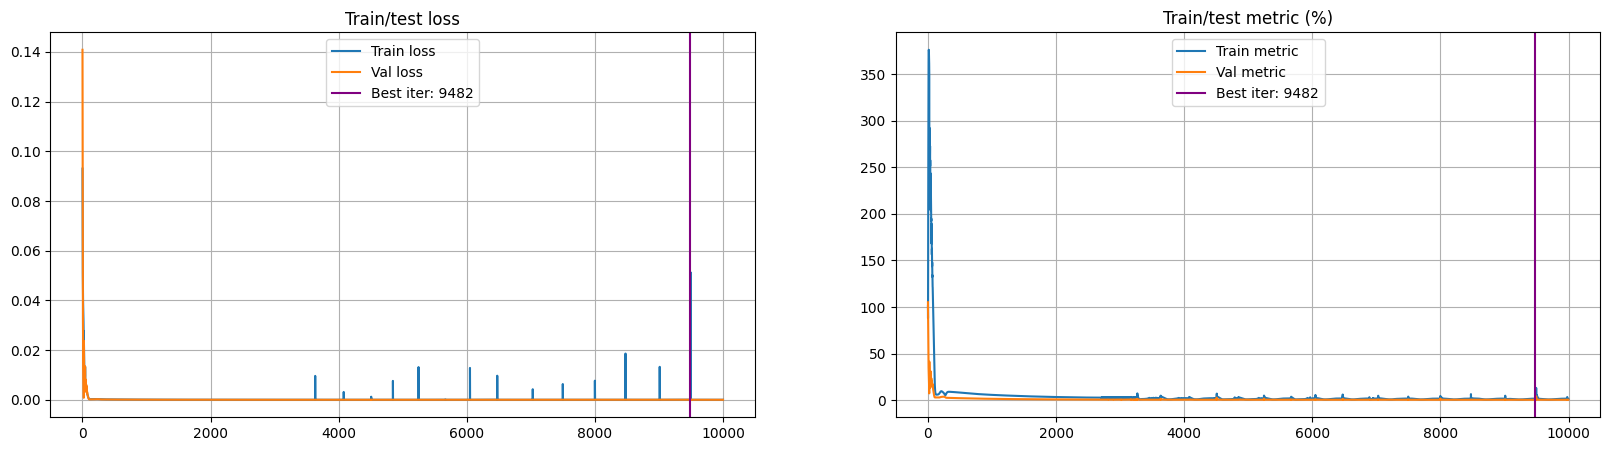

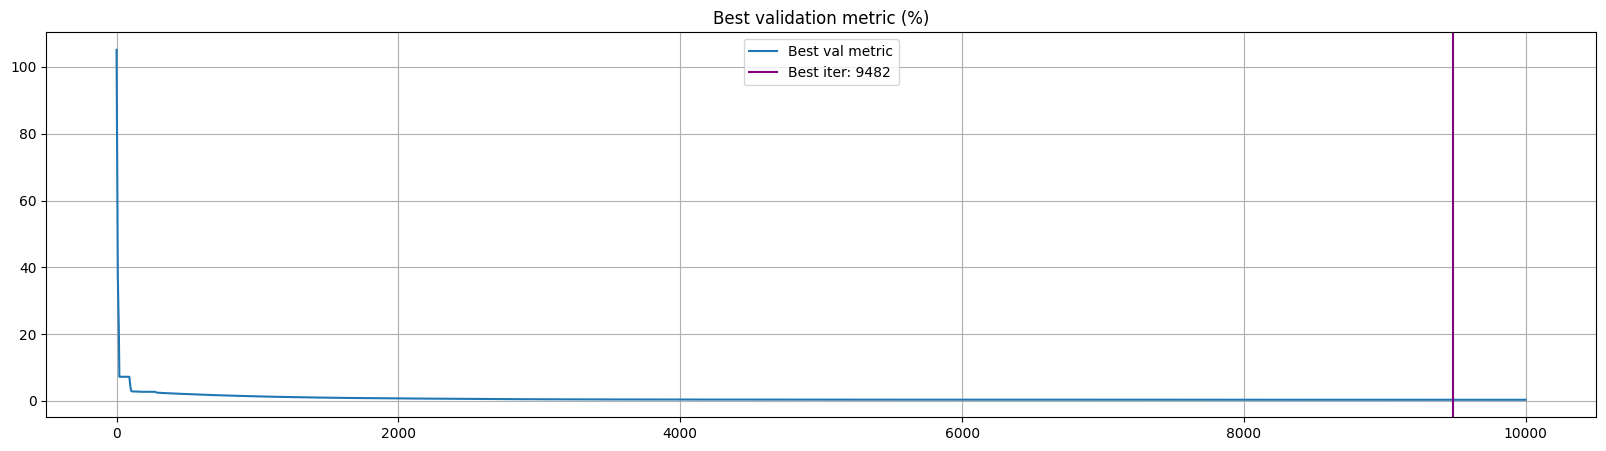

In [31]:
Train_Eval_Plot.plot_train_res(train_res)

In [32]:
model.load_state_dict(train_res["best model"])

<All keys matched successfully>

In [33]:
eval_res = Train_Eval_Plot.eval(model, test_loader, metrics_dict[metric_name], criterion, device= "cpu")

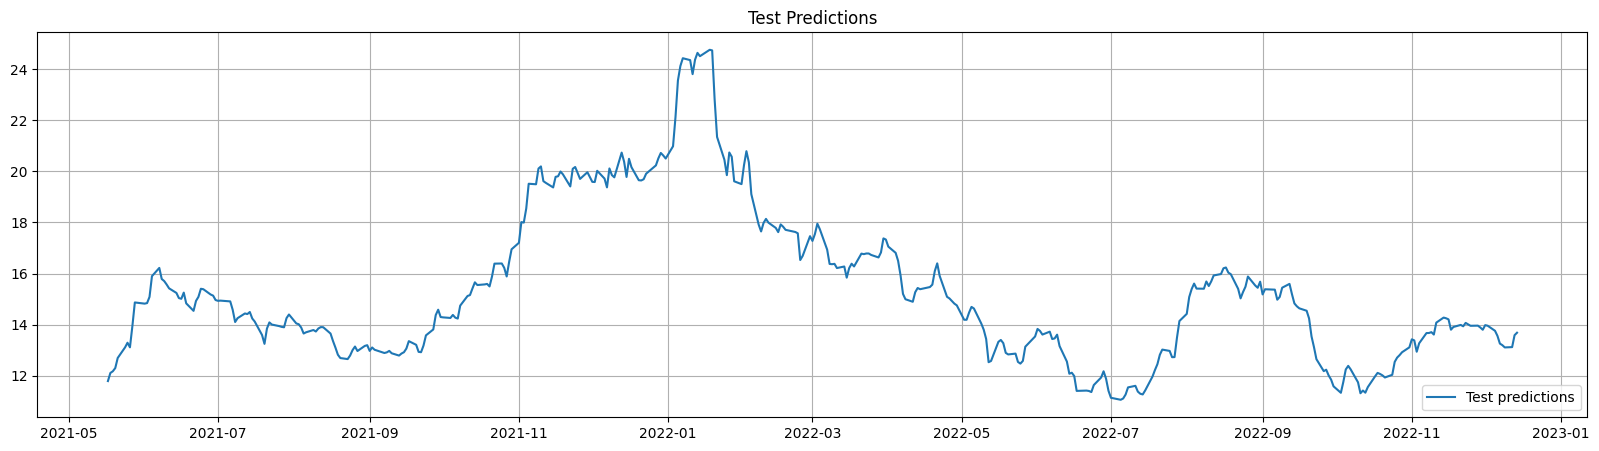

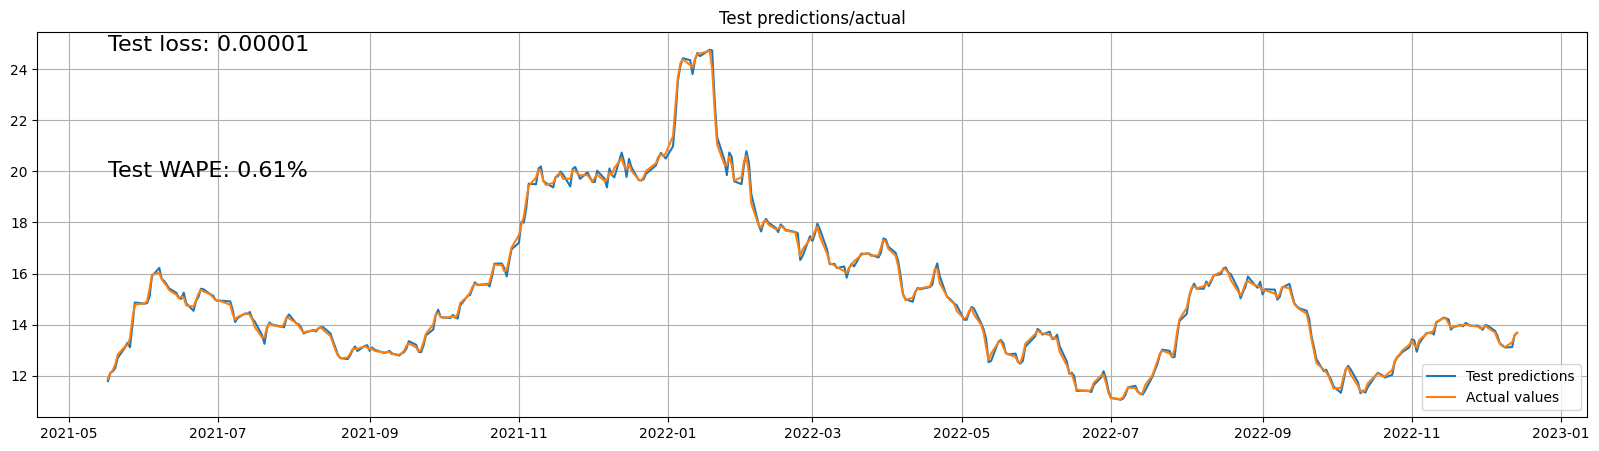

In [40]:
Train_Eval_Plot.plot_eval_res(eval_res, y_test_scaled, scaler, dates_test_y, start= -400, end= None)

# Вычисление доходностей

In [35]:
predicted_open_prices = pd.DataFrame({
    "Test predictions": scaler.inverse_transform(eval_res["test preds"]).reshape(-1),
    "Test ground trouth": y_test.reshape(-1),
}, index= pd.to_datetime(dates_test_y.reshape(-1), dayfirst= True))

predicted_open_prices

,Test predictions,Test ground trouth
2017-12-20,12.712923,12.722500
2017-12-21,12.743163,12.715000
2017-12-22,12.696941,12.657499
2017-12-26,12.602010,12.592500
2017-12-27,12.572820,12.547500
...,...,...
2022-12-08,13.197771,13.160000
2022-12-09,13.108354,13.120000
2022-12-12,13.120818,13.304999
2022-12-13,13.588154,13.582500


In [36]:
pct_change = predicted_open_prices.pct_change()[1:]

predicted_pct_changes = np.array(pct_change["Test predictions"])
test_values = np.array(pct_change["Test ground trouth"])
dates = list(predicted_open_prices.index)[1:]

metric_value = metrics_dict.metrics_dict["WAPE"]()(predicted_pct_changes, test_values)

WAPE: 65.48%


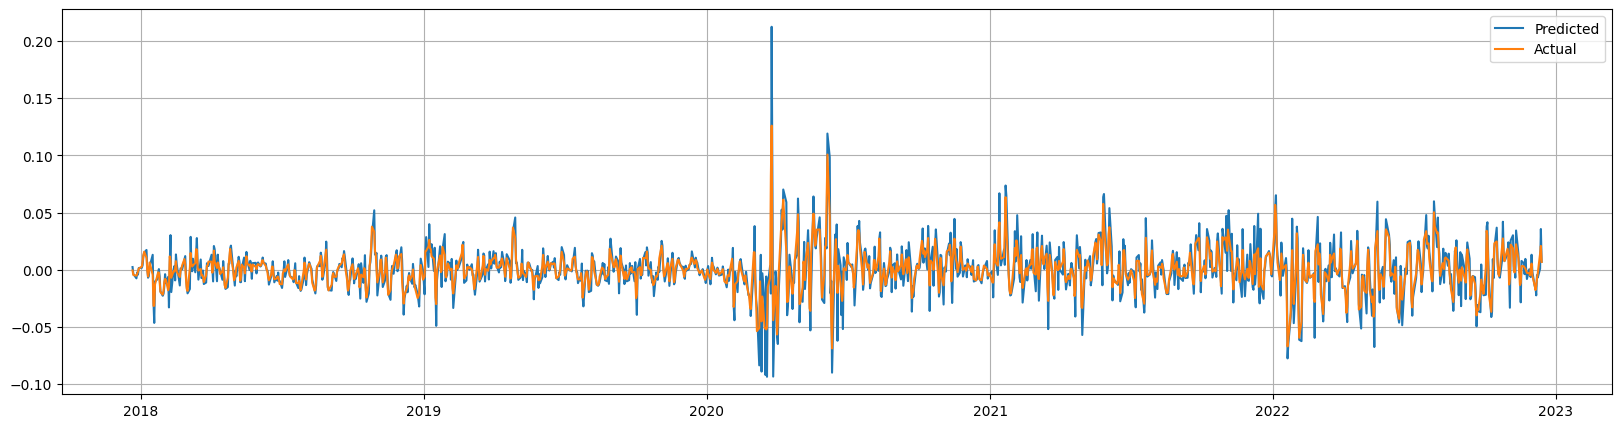

In [42]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 20, 5
print(f"WAPE: {metric_value:.2f}%")
plt.plot(dates[-0:], predicted_pct_changes[-0:], label= "Predicted")
plt.plot(dates[-0:], test_values[-0:], label= "Actual")
plt.grid(True)
plt.legend(loc= "best")
plt.show()